# Fixed feature swap experiments

Fix the fact that the experiment that shows the median time to pass as the number of feature increases confounds the target function complexity with the number of features.

In [1]:
from collections import defaultdict
import sys
from typing import Sequence
sys.path.append('../')

from hl_gauss_pytorch import HLGaussLoss, HLGaussLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

from idbd import IDBD
from adam import Adam

%matplotlib inline

In [2]:
def bin_sequential_data(data: Sequence, n_bins: int = 100):
    remainder = len(data) % n_bins
    if remainder != 0:
        data = data[:-remainder]
    return np.array(data).reshape(n_bins, -1).mean(axis=1)

def ltu(val: np.array, threshold: float = 0.0):
    return np.where(val > threshold, 1.0, 0.0)

def gen_sparse_linear_weights(n_inputs: int, n_output: int, sparsity: float = 0.5):
    """Similar to kaiming uniform while accounting for the sparsity."""
    weights = (torch.rand(n_output, n_inputs) * 2 - 1) / np.sqrt(n_inputs * (1 - sparsity))
    sparsity_mask = torch.rand_like(weights) < sparsity
    weights = weights * sparsity_mask
    return weights

In [3]:
torch.manual_seed(42)

n_inputs = 50
n_features = 100
noise_strength = 0.1

true_weights = torch.randn(1, n_inputs)
feature_weights = gen_sparse_linear_weights(n_inputs, n_features, sparsity=0.5)
model = torch.nn.Linear(n_features, 1, bias=False)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.01, init_lr=0.01, autostep=True)
# optimizer = Adam(model.parameters(), lr=0.001)

In [4]:
# Train until convergence

losses = []

for i in range(1000000):
    X = torch.randn(n_inputs, dtype=torch.float)
    true_features = feature_weights @ X
    noisy_features = true_features + torch.randn(n_features) * noise_strength
    y_pred = model(noisy_features)
    target = true_weights @ X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    param_inputs = {model.weight: noisy_features}
    optimizer.zero_grad()
    optimizer.step(loss, y_pred, param_inputs)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= 0:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-1000:]))

Number of steps: 7001
Loss: 0.9415763513960801


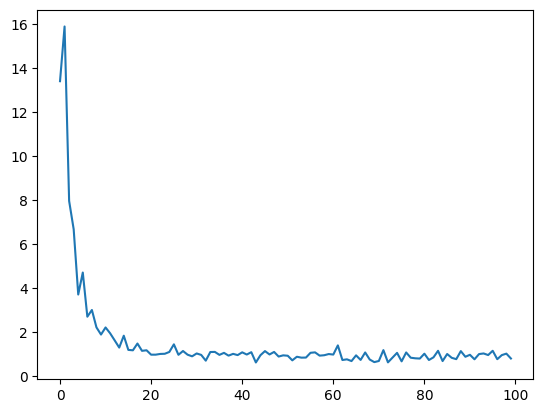

In [5]:
plt.plot(bin_sequential_data(losses))

In [6]:
# Add new inputs
new_model = torch.nn.Linear(n_features * 2, 1, bias=False)
torch.nn.init.zeros_(new_model.weight)
new_model.weight.data[:, :n_features] = model.weight.data

new_optimizer = IDBD(new_model.parameters(), meta_lr=0.01, init_lr=0.01, autostep=True)

old_state = optimizer.state[model.weight]
new_state = new_optimizer.state[new_model.weight]
for key, value in old_state.items():
    new_state[key][:, :n_features] = value

model = new_model
optimizer = new_optimizer

In [7]:
# Train until convergence

losses_2 = []

initial_weight_magnitudes = torch.abs(model.weight.data[0, :n_features].clone())
time_to_pass = torch.inf * torch.ones_like(initial_weight_magnitudes)

for i in range(200000):
    X = torch.randn(n_inputs, dtype=torch.float)
    true_features = feature_weights @ X
    noisy_features = true_features + torch.randn(n_features) * noise_strength
    all_features = torch.cat([noisy_features, true_features], dim=0)
    y_pred = model(all_features)
    target = true_weights @ X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses_2.append(loss.item())

    param_inputs = {model.weight: all_features}
    optimizer.zero_grad()
    optimizer.step(loss, y_pred, param_inputs)
    
    if i % 100 == 0:
        orig_weights = model.weight.data[0, :n_features]
        new_weights = model.weight.data[0, n_features:]
        
        weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
        new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
        time_to_pass = torch.where(weight_surpassed, new_time_to_pass, time_to_pass)
    
    if i > 50000 and i % 1000 == 0 and np.mean(losses_2[-20000:-10000]) - np.mean(losses_2[-10000:]) <= 0:
        break

print('Number of steps:', len(losses_2))
print('Loss:', np.mean(losses_2[-1000:]))

KeyboardInterrupt: 

In [ ]:
# print(model.weight.data[0, :n_inputs])
# print(model.weight.data[0, n_inputs:])
# initial_weight_magnitudes


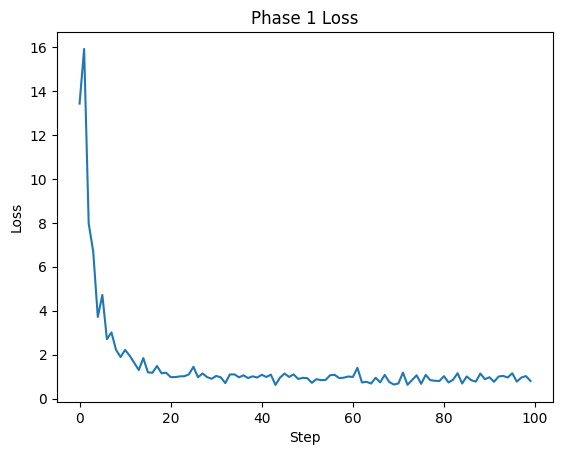

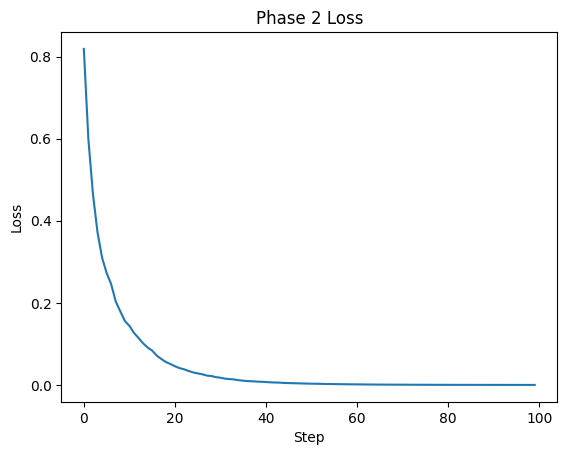

In [38]:
plt.plot(bin_sequential_data(losses))
plt.title('Phase 1 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot(bin_sequential_data(losses_2))
plt.title('Phase 2 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


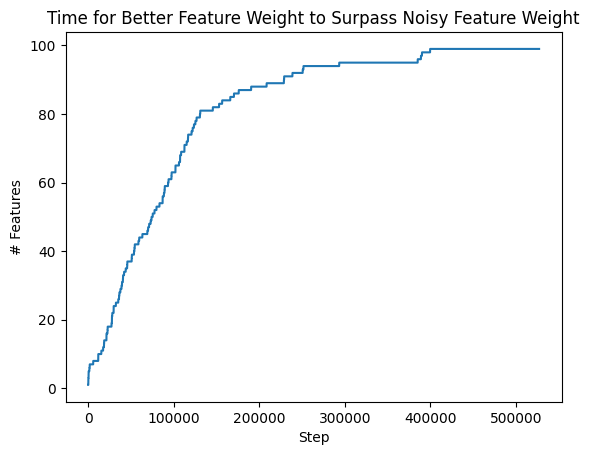

In [39]:
sorted_time_to_pass = sorted(time_to_pass.tolist())
pass_idx = 0
prev_pass_step = 0
plot_values = []
for pass_step in sorted_time_to_pass:
    if np.isinf(pass_step):
        plot_values.extend([pass_idx] * int(len(losses_2) - prev_pass_step))
        break
    plot_values.extend([pass_idx] * int(pass_step - prev_pass_step))
    prev_pass_step = pass_step
    pass_idx += 1

plt.plot(plot_values)
plt.title('Time for Better Feature Weight to Surpass Noisy Feature Weight')
plt.xlabel('Step')
plt.ylabel('# Features')
plt.show()



In [3]:
def train_linear_model(model, optimizer, inputs, targets, check_interval=200, callback=None):
    losses = []
    
    for i, (input_val, target_val) in enumerate(zip(inputs, targets)):
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: inputs[i]}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        if callback is not None:
            force_break = callback(**locals())
            if force_break:
                break

        if (
            i > check_interval * 2
            and i % check_interval == 0
            and np.mean(losses[-check_interval*2:-check_interval]) - np.mean(losses[-check_interval:]) <= 0
        ):
            break
    
    return losses


def linear_init_model_and_optimizer(n_inputs, n_features, sparsity, meta_lr=0.01, init_lr=0.01):
    true_weights = gen_sparse_linear_weights(n_inputs, 1, sparsity)
    feature_weights = gen_sparse_linear_weights(n_inputs, n_features, sparsity)
    model = torch.nn.Linear(n_features, 1, bias=False)
    torch.nn.init.zeros_(model.weight)

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    return model, feature_weights, true_weights, optimizer


def linear_add_new_features(model, optimizer, n_features):
    new_model = torch.nn.Linear(n_features * 2, 1, bias=False)
    torch.nn.init.zeros_(new_model.weight)
    new_model.weight.data[:, :n_features] = model.weight.data

    optimizer_cls = optimizer.__class__
    new_optimizer = optimizer_cls(
        new_model.parameters(),
        meta_lr = optimizer.defaults['meta_lr'],
        init_lr = optimizer.init_lr,
        autostep = True,
    )

    old_state = optimizer.state[model.weight]
    new_state = new_optimizer.state[new_model.weight]
    for key, value in old_state.items():
        new_state[key][:, :n_features] = value

    return new_model, new_optimizer


def run_feature_swap_experiment(
    n_inputs,
    n_features,
    sparsity,
    noise_strength,
    max_steps = 300000,
    init_fn = linear_init_model_and_optimizer,
    add_new_features_fn = linear_add_new_features,
    train_fn = train_linear_model,
):
    ### Setup the model and optimizer ###
    
    model, feature_weights, true_weights, optimizer = init_fn(n_inputs, n_features, sparsity)
    
    ### Generate the inputs and targets, then train ###
    
    inputs = torch.randn((max_steps, n_inputs), dtype=torch.float)
    true_features = inputs @ feature_weights.T
    noisy_features = true_features + torch.randn(max_steps, n_features) * noise_strength
    targets = inputs @ true_weights.T

    losses = train_fn(model, optimizer, noisy_features, targets, check_interval=2000)
    
    ### Add in the new features ###

    model, optimizer = add_new_features_fn(model, optimizer, n_features)

    ### Generate the new inputs and targets ###
    
    inputs = torch.randn((max_steps, n_inputs), dtype=torch.float)
    true_features = inputs @ feature_weights.T
    noisy_features = true_features + torch.randn(max_steps, n_features) * noise_strength
    full_features = torch.cat([noisy_features, true_features], dim=1)
    targets = inputs @ true_weights.T
    
    ### Define a callback for computing time to pass ###
    
    time_to_pass = torch.inf * torch.ones(n_features, dtype=torch.float)
    def compute_time_to_pass(**kwargs):
        nonlocal time_to_pass
        orig_weights = model.weight.data[0, :n_features]
        new_weights = model.weight.data[0, n_features:]
        
        weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
        new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, kwargs['i']), time_to_pass)
        time_to_pass = torch.where(weight_surpassed, new_time_to_pass, time_to_pass)
        
        # Force a break if the median time to pass is finite
        return not torch.isinf(time_to_pass.median())
    
    ### Train the model for the second phase ###

    losses_2 = train_fn(
        model, optimizer, full_features, targets,
        check_interval=10000, callback=compute_time_to_pass,
    )
    
    return {
        'phase_one_losses': losses,
        'phase_two_losses': losses_2,
        'time_to_pass': time_to_pass,
    }



# Sweeps

In [31]:
seeds = list(range(5))

n_inputs_sweep_vals = [5, 10, 20, 50, 100]
feature_input_multiplier = 5
base_n_inputs = 20

n_feature_sweep_vals = [10, 20, 50, 100, 200, 400]
init_lr_sweep_vals = [0.00001, 0.0001, 0.001, 0.01]
base_n_features = 50

noise_sweep_vals = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
base_noise = 0.1

base_sparsity = 0.5

In [36]:
print('Running n_inputs sweep...')
n_inputs_sweep_results = defaultdict(list)
total_runs = len(n_inputs_sweep_vals) * len(seeds)
bar = tqdm(total=total_runs)
for n_inputs in n_inputs_sweep_vals:
    for seed in seeds:
        torch.manual_seed(seed)
        # n_features = n_inputs * feature_input_multiplier
        # results = run_feature_swap_experiment(n_inputs, n_features, base_sparsity, base_noise)
        results = run_feature_swap_experiment(n_inputs, base_n_features, base_sparsity, base_noise)
        n_inputs_sweep_results[n_inputs].append(results)
        bar.update(1)

Running n_inputs sweep...


100%|██████████| 30/30 [1:57:20<00:00, 234.68s/it]


In [6]:
print('Running n_features sweep...')
n_feature_sweep_results = defaultdict(list)
total_runs = len(n_feature_sweep_vals) * len(init_lr_sweep_vals) * len(seeds)
bar = tqdm(total=total_runs)
for n_features in n_feature_sweep_vals:
    for init_lr in init_lr_sweep_vals:
        for seed in seeds:
            torch.manual_seed(seed)
            init_fn = lambda *args, **kwargs: linear_init_model_and_optimizer(*args, **kwargs, init_lr=init_lr)
            results = run_feature_swap_experiment(base_n_inputs, n_features, base_sparsity, base_noise, init_fn=init_fn)
            n_feature_sweep_results[(n_features, init_lr)].append(results)
            bar.update(1)

Running n_features sweep...


100%|██████████| 25/25 [08:20<00:00, 20.02s/it]


In [33]:
print('Running noise sweep...')
noise_sweep_results = defaultdict(list)
total_runs = len(noise_sweep_vals) * len(seeds)
bar = tqdm(total=total_runs)
for noise in noise_sweep_vals:
    for seed in seeds:
        torch.manual_seed(seed)
        results = run_feature_swap_experiment(base_n_inputs, base_n_features, base_sparsity, noise)
        noise_sweep_results[noise].append(results)
        bar.update(1)

Running noise sweep...


100%|██████████| 30/30 [12:27<00:00,  7.34s/it]

In [4]:
def plot_median_times_to_pass(time_to_pass):
    sorted_time_to_pass = sorted(time_to_pass.tolist())
    pass_idx = 0
    prev_pass_step = 0
    plot_values = []
    for pass_step in sorted_time_to_pass:
        if np.isinf(pass_step):
            plot_values.extend([pass_idx] * int(len(losses_2) - prev_pass_step))
            break
        plot_values.extend([pass_idx] * int(pass_step - prev_pass_step))
        prev_pass_step = pass_step
        pass_idx += 1

    plt.plot(plot_values)

### Input count sweep

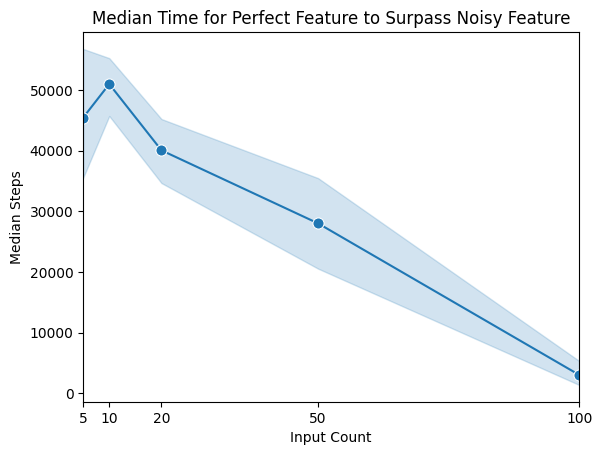

In [37]:
df_rows = []
for n_inputs, results in n_inputs_sweep_results.items():
    for result in results:
        df_rows.append({
            'n_inputs': n_inputs,
            'time_to_pass': result['time_to_pass'].median().item(),
        })
df = pd.DataFrame(df_rows)
# df.dropna(inplace=True)

# Create line plot with confidence interval
sns.lineplot(data=df, x='n_inputs', y='time_to_pass', marker='o', markersize=8, 
            err_style='band', errorbar=('ci', 95))

x_vals = df['n_inputs'].unique()
plt.xticks(x_vals, x_vals)

plt.xlim(x_vals[0], x_vals[-1])

plt.title('Median Time for Perfect Feature to Surpass Noisy Feature')
plt.xlabel('Input Count')
plt.ylabel('Median Steps')
plt.show()


### Feature count sweep

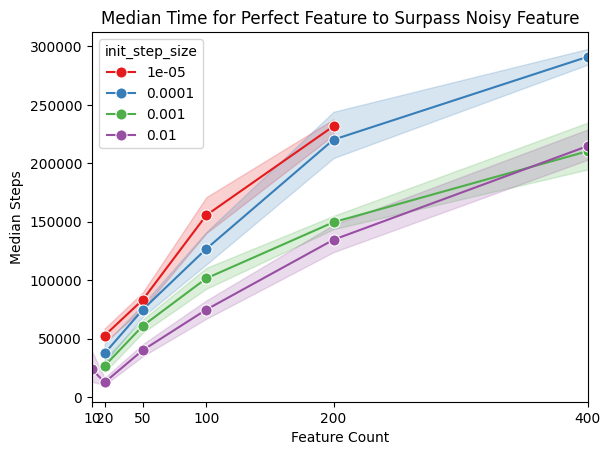

In [9]:
df_rows = []
for (n_features, init_lr), results in n_feature_sweep_results.items():
    for result in results:
        df_rows.append({
            'n_features': n_features,
            'init_step_size': init_lr,
            'time_to_pass': result['time_to_pass'].median().item(),
        })
df = pd.DataFrame(df_rows)

# Create line plot with confidence interval
sns.lineplot(
    data=df, x='n_features', y='time_to_pass', hue='init_step_size', marker='o',
    markersize=8, err_style='band', errorbar=('ci', 95), palette='Set1',
)

x_vals = df['n_features'].unique()
plt.xticks(x_vals, x_vals)

plt.xlim(x_vals[0], x_vals[-1])

plt.title('Median Time for Perfect Feature to Surpass Noisy Feature')
plt.xlabel('Feature Count')
plt.ylabel('Median Steps')
plt.show()


### Noise strength sweep

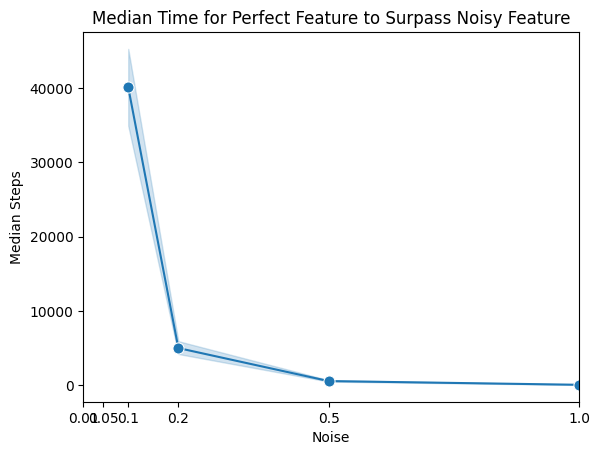

In [35]:
df_rows = []
for noise, results in noise_sweep_results.items():
    for result in results:
        df_rows.append({
            'noise': noise,
            'time_to_pass': result['time_to_pass'].median().item(),
        })
df = pd.DataFrame(df_rows)

# Create line plot with confidence interval
sns.lineplot(data=df, x='noise', y='time_to_pass', marker='o', markersize=8, 
            err_style='band', errorbar=('ci', 95))

x_vals = df['noise'].unique()
plt.xticks(x_vals, x_vals)

plt.xlim(x_vals[0], x_vals[-1])

plt.title('Median Time for Perfect Feature to Surpass Noisy Feature')
plt.xlabel('Noise')
plt.ylabel('Median Steps')
plt.show()
